<a href="https://colab.research.google.com/github/ramadharmishra/Embedding_Model/blob/main/embedding_product_suggestion_based_on_customer_query.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install openai sentence-transformers numpy scikit-learn matplotlib pandas -q

In [ ]:
from google.colab import userdata
import os

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

# Verify
status = "✅ Loaded" if os.environ.get("OPENAI_API_KEY") else "❌ MISSING"
print(f"OPENAI_API_KEY: {status}")

OPENAI_API_KEY: ✅ Loaded


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openai import OpenAI
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

# Initialize OpenAI client
openai_client = OpenAI()

print("Client initialized ✅")

Client initialized ✅


In [ ]:
def get_openai_embeddings(texts, model="text-embedding-3-small"):
    """
    Generate embeddings for a list of texts using OpenAI's Embeddings API.
    Supports batching — send up to 2048 texts in one call.

    Args:
        texts: list of strings to embed
        model: 'text-embedding-3-small' (1536d) or 'text-embedding-3-large' (3072d)

    Returns: numpy array of shape (len(texts), embedding_dim)
    """
    response = openai_client.embeddings.create(
        model=model,
        input=texts
    )
    # Extract embedding vectors in the correct order
    embeddings = [item.embedding for item in response.data]
    return np.array(embeddings)


def compute_similarity_matrix(embeddings):
    """Compute pairwise cosine similarity matrix for a set of embeddings."""
    return cosine_similarity(embeddings)


def show_similarity_heatmap(texts, sim_matrix, title="Cosine Similarity"):
    """Display a heatmap of pairwise cosine similarities."""
    # Truncate long text labels for display
    labels = [t[:50] + "..." if len(t) > 50 else t for t in texts]

    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(sim_matrix, cmap='YlOrRd', vmin=0, vmax=1)
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels(labels, fontsize=8)

    # Annotate cells with similarity scores
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, f"{sim_matrix[i][j]:.2f}",
                    ha='center', va='center', fontsize=7,
                    color='white' if sim_matrix[i][j] > 0.7 else 'black')

    plt.colorbar(im, ax=ax, label='Cosine Similarity')
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

print("Helper functions defined ✅")

Helper functions defined ✅


# Task 1 :

## Embeddings: Product Descriptions

## Business Scenario
A retail bank wants to build a product recommendation engine. When a customer describes what they need (e.g., "I want to save for retirement"), the system should match them to the most relevant banking product.

## Define Vector embedding product descriptions and computing how similar they are to each other and to customer queries.

In [ ]:
# Banking product descriptions
products = [
    "High-yield savings account with 4.5% APY, no minimum balance, FDIC insured up to $250,000",
    "Fixed deposit account with guaranteed returns, lock-in periods of 6 to 60 months",
    "Retirement pension plan with tax benefits, employer matching, and diversified fund options",
    "Personal home loan at competitive interest rates with flexible EMI options up to 30 years",
    "Business line of credit for working capital needs, revolving facility up to $500,000",
    "Student education loan covering tuition, living expenses, with grace period after graduation",
    "Credit card with cashback rewards on dining, travel, and online shopping",
    "Travel insurance covering medical emergencies, trip cancellation, and lost baggage abroad",
]

# Generate embeddings
print("Generating embeddings for 8 banking products...")
product_embeddings = get_openai_embeddings(products, model="text-embedding-3-small")

print(f"Embedding shape: {product_embeddings.shape}")
print(f"Each product → vector of {product_embeddings.shape[1]} dimensions")

Generating embeddings for 8 banking products...
Embedding shape: (8, 1536)
Each product → vector of 1536 dimensions


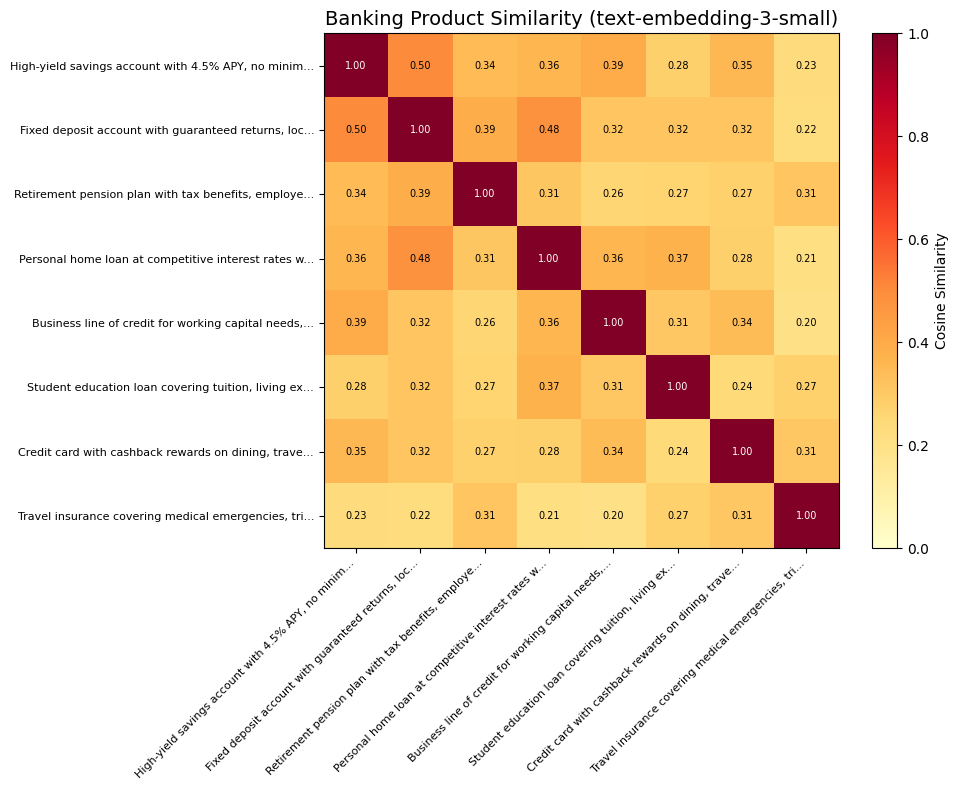

In [ ]:
# Compute and display the pairwise similarity matrix
sim_matrix = compute_similarity_matrix(product_embeddings)
show_similarity_heatmap(products, sim_matrix, title="Banking Product Similarity (text-embedding-3-small)")

In [ ]:
# Now test with customer queries — find the best matching product
customer_queries = [
    "I want to grow my money safely with good interest",
    "I need money to buy my first house",
    "My daughter is going to college next year and needs financial help",
    "I'm planning a trip to Europe and want protection against emergencies",
    "I want to save for my retirement with tax advantages",
]

query_embeddings = get_openai_embeddings(customer_queries)

# Compute similarity between each query and all products
query_product_sim = cosine_similarity(query_embeddings, product_embeddings)

# Show best match for each query
print("🏦 Customer Query → Best Matching Product\n")

for i, query in enumerate(customer_queries):
    best_idx = np.argmax(query_product_sim[i])
    score = query_product_sim[i][best_idx]
    print(f"Query: \"{query}\"")
    print(f"  → Match: {products[best_idx]}")
    print(f"  → Score: {score:.4f}\n")


🏦 Customer Query → Best Matching Product

Query: "I want to grow my money safely with good interest"
  → Match: Fixed deposit account with guaranteed returns, lock-in periods of 6 to 60 months
  → Score: 0.4481

Query: "I need money to buy my first house"
  → Match: Personal home loan at competitive interest rates with flexible EMI options up to 30 years
  → Score: 0.3186

Query: "My daughter is going to college next year and needs financial help"
  → Match: Student education loan covering tuition, living expenses, with grace period after graduation
  → Score: 0.3955

Query: "I'm planning a trip to Europe and want protection against emergencies"
  → Match: Travel insurance covering medical emergencies, trip cancellation, and lost baggage abroad
  → Score: 0.5973

Query: "I want to save for my retirement with tax advantages"
  → Match: Retirement pension plan with tax benefits, employer matching, and diversified fund options
  → Score: 0.5981

